<a href="https://colab.research.google.com/github/mlvlab/Prompt_Tuning_tutorial/blob/main/VLM_Prompt_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Session: Vision-Language Model (VLM) Prompt Tuning

## Contents
[1] Preparation \
[2] Load pre-trained CLIP Model \
[3] CoOpCLIP Implementation \
[4] CoOpCLIP Training


## References
- Learning to Prompt for Vision-Language Models (CoOp): https://github.com/KaiyangZhou/CoOp
- Prompt Learning via Meta-Regularization (ProMetaR): https://github.com/mlvlab/ProMetaR

---
# [1] Preparation

#### 1. Clone github repository

In [ ]:
!git clone https://github.com/mlvlab/ProMetaR.git

fatal: destination path 'ProMetaR' already exists and is not an empty directory.


- It will make ProMetaR folder on left side.

#### 2. Install Requirements

In [ ]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121

%cd ProMetaR/

!git clone https://github.com/KaiyangZhou/Dassl.pytorch.git
%cd Dassl.pytorch/

# Install dependencies
!pip install -r requirements.txt
!cp -r dassl ../
# Install this library (no need to re-build if the source code is modified)
# !python setup.py develop
%cd ..

!pip install -r requirements.txt

Looking in indexes: https://download.pytorch.org/whl/cu121
/content/ProMetaR
fatal: destination path 'Dassl.pytorch' already exists and is not an empty directory.
/content/ProMetaR/Dassl.pytorch
/content/ProMetaR
  Using cached ftfy-6.1.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached learn2learn-0.2.0.tar.gz (7.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached gsutil-5.35-py3-none-any.whl
  Using cached qpth-0.0.18-py3-none-any.whl
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached argcomplete-3.6.3-py3-none-any.whl.metadata (16 kB)
  Using cached crcmod-1.7-cp312-cp312-linux_x86_64.whl
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
  Using cached gcs_oauth2_boto_plugin-3.3-py3-none-any.whl
  Using cached google_apitools-0.5.35-py3-none-any.whl.metadata (2.7 kB)
  Using cached httplib2-0.20.4-py3-none-any.whl.metadata (2.5 kB)
  Using cached google_reauth-0.1.1-py2.py3-none-any.whl.met

- *If an error occurs, click ‘Run Session Again’ and then restart the runtime from the beginning.*

#### 3. Load Requirements and functions

In [ ]:
import os.path as osp
from collections import OrderedDict
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
import torchvision.transforms as transforms
import torch
from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import time
from tqdm import tqdm
import datetime
import argparse
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
from dassl.engine import TRAINER_REGISTRY, TrainerX
from dassl.metrics import compute_accuracy
from dassl.utils import load_pretrained_weights, load_checkpoint
from dassl.optim import build_optimizer, build_lr_scheduler

# custom
import datasets.oxford_pets
import datasets.oxford_flowers
import datasets.fgvc_aircraft
import datasets.dtd
import datasets.eurosat
import datasets.stanford_cars
import datasets.food101
import datasets.sun397
import datasets.caltech101
import datasets.ucf101
import datasets.imagenet
import datasets.imagenet_sketch
import datasets.imagenetv2
import datasets.imagenet_a
import datasets.imagenet_r

In [ ]:
def print_args(args, cfg):
    print("***************")
    print("** Arguments **")
    print("***************")
    optkeys = list(args.__dict__.keys())
    optkeys.sort()
    for key in optkeys:
        print("{}: {}".format(key, args.__dict__[key]))
    print("************")
    print("** Config **")
    print("************")
    print(cfg)

def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root
    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir
    if args.seed:
        cfg.SEED = args.seed
    if args.trainer:
        cfg.TRAINER.NAME = args.trainer
    cfg.DATASET.NUM_SHOTS = 16
    cfg.DATASET.SUBSAMPLE_CLASSES = args.subsample_classes
    cfg.DATALOADER.TRAIN_X.BATCH_SIZE = args.train_batch_size
    cfg.OPTIM.MAX_EPOCH = args.epoch

def extend_cfg(cfg):
    """
    Add new config variables.
    """
    from yacs.config import CfgNode as CN
    cfg.TRAINER.COOP = CN()
    cfg.TRAINER.COOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COOP.CSC = False  # class-specific context
    cfg.TRAINER.COOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = "end"  # 'middle' or 'end' or 'front'
    cfg.TRAINER.COCOOP = CN()
    cfg.TRAINER.COCOOP.N_CTX = 4  # number of context vectors
    cfg.TRAINER.COCOOP.CTX_INIT = "a photo of a"  # initialization words
    cfg.TRAINER.COCOOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.PROMETAR = CN()
    cfg.TRAINER.PROMETAR.N_CTX_VISION = 4  # number of context vectors at the vision branch
    cfg.TRAINER.PROMETAR.N_CTX_TEXT = 4  # number of context vectors at the language branch
    cfg.TRAINER.PROMETAR.CTX_INIT = "a photo of a"  # initialization words
    cfg.TRAINER.PROMETAR.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.PROMETAR.PROMPT_DEPTH_VISION = 9  # Max 12, minimum 0, for 0 it will be using shallow IVLP prompting (J=1)
    cfg.TRAINER.PROMETAR.PROMPT_DEPTH_TEXT = 9  # Max 12, minimum 0, for 0 it will be using shallow IVLP prompting (J=1)
    cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new
    cfg.TRAINER.PROMETAR.ADAPT_LR = 0.0005
    cfg.TRAINER.PROMETAR.LR_RATIO = 0.0005
    cfg.TRAINER.PROMETAR.FAST_ADAPTATION = False
    cfg.TRAINER.PROMETAR.MIXUP_ALPHA = 0.5
    cfg.TRAINER.PROMETAR.MIXUP_BETA = 0.5
    cfg.TRAINER.PROMETAR.DIM_RATE=8
    cfg.OPTIM_VNET = CN()
    cfg.OPTIM_VNET.NAME = "adam"
    cfg.OPTIM_VNET.LR = 0.0003
    cfg.OPTIM_VNET.WEIGHT_DECAY = 5e-4
    cfg.OPTIM_VNET.MOMENTUM = 0.9
    cfg.OPTIM_VNET.SGD_DAMPNING = 0
    cfg.OPTIM_VNET.SGD_NESTEROV = False
    cfg.OPTIM_VNET.RMSPROP_ALPHA = 0.99
    cfg.OPTIM_VNET.ADAM_BETA1 = 0.9
    cfg.OPTIM_VNET.ADAM_BETA2 = 0.999
    cfg.OPTIM_VNET.STAGED_LR = False
    cfg.OPTIM_VNET.NEW_LAYERS = ()
    cfg.OPTIM_VNET.BASE_LR_MULT = 0.1
    # Learning rate scheduler
    cfg.OPTIM_VNET.LR_SCHEDULER = "single_step"
    # -1 or 0 means the stepsize is equal to max_epoch
    cfg.OPTIM_VNET.STEPSIZE = (-1, )
    cfg.OPTIM_VNET.GAMMA = 0.1
    cfg.OPTIM_VNET.MAX_EPOCH = 10
    # Set WARMUP_EPOCH larger than 0 to activate warmup training
    cfg.OPTIM_VNET.WARMUP_EPOCH = -1
    # Either linear or constant
    cfg.OPTIM_VNET.WARMUP_TYPE = "linear"
    # Constant learning rate when type=constant
    cfg.OPTIM_VNET.WARMUP_CONS_LR = 1e-5
    # Minimum learning rate when type=linear
    cfg.OPTIM_VNET.WARMUP_MIN_LR = 1e-5
    # Recount epoch for the next scheduler (last_epoch=-1)
    # Otherwise last_epoch=warmup_epoch
    cfg.OPTIM_VNET.WARMUP_RECOUNT = True

def setup_cfg(args):
    cfg = get_cfg_default()
    extend_cfg(cfg)
    # 1. From the dataset config file
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    # 2. From the method config file
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    # 3. From input arguments
    reset_cfg(cfg, args)
    cfg.freeze()
    return cfg

#### 3. Download EuroSAT dataset

In [ ]:
%mkdir outputs
%mkdir data

%cd data
%mkdir eurosat
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip EuroSAT.zip

!unzip -o EuroSAT.zip -d eurosat/
%cd eurosat
!gdown 1Ip7yaCWFi0eaOFUGga0lUdVi_DDQth1o

%cd ../../


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: eurosat/2750/SeaLake/SeaLake_1817.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2902.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2570.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1004.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_174.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2111.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2388.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1948.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_838.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2738.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1999.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2359.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2660.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1775.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_605.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2201.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_264.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1314.jpg  
  inflating: e

The structure of the data folder inside the ProMetaR folder should be as follows:

	•	eurosat/2750
	•	eurosat/split_zhou_EuroSAT.json

---

# [2] Load pre-trained CLIP Model

In [ ]:
_tokenizer = _Tokenizer()

def load_clip_to_cpu(cfg): # Load CLIP
    backbone_name = cfg.MODEL.BACKBONE.NAME
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    if cfg.TRAINER.NAME == "":
      design_trainer = "CoOp"
    else:
      design_trainer = cfg.TRAINER.NAME
    design_details = {"trainer": design_trainer,
                      "vision_depth": 0,
                      "language_depth": 0, "vision_ctx": 0,
                      "language_ctx": 0}
    model = clip.build_model(state_dict or model.state_dict(), design_details)

    return model

In [ ]:
from dassl.config import get_cfg_default
cfg = get_cfg_default()
cfg.MODEL.BACKBONE.NAME = "ViT-B/16" # Set the vision encoder backbone of CLIP to ViT.
clip_model = load_clip_to_cpu(cfg)

100%|████████████████████████████████████████| 351M/351M [00:01<00:00, 293MiB/s]


### Check CLIP model

In [ ]:
print(clip_model)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

# [3] CoOpCLIP Implementation

CoOpCLIP is composed of pre-trained CLIP Text encoder, pre-trained CLIP Image encoder, and learnable prompt.

### Make Module 1: CLIP Text Encoder

**Input**
- token prefix (SOS token) + learnable prompt + class label + token suffix (CLS token)

**Output**
- text feature of input prompts

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts): # Call model forward
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        return x

### Make Module 2: CLIP Image Encoder

**Input**
- image

**Output**
- image feature

In [ ]:
print(clip_model.visual)

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

### Make Module 3: Learnable Prompt

**Output**
- Learnable prompt

In [ ]:
class CoOpPromptLearner(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        n_cls = len(classnames)
        n_ctx = cfg.TRAINER.COOP.N_CTX
        ctx_init = cfg.TRAINER.COOP.CTX_INIT
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution
        cfg_imsize = cfg.INPUT.SIZE[0]
        assert cfg_imsize == clip_imsize, f"cfg_imsize ({cfg_imsize}) must equal to clip_imsize ({clip_imsize})"

        ### Learnable Prompts Initialization ###
        if ctx_init:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            if cfg.TRAINER.COOP.CSC:
                print("Initializing class-specific contexts")
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim, dtype=dtype)
            else:
                print("Initializing a generic context")
                ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)
        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")
        self.ctx = nn.Parameter(ctx_vectors)  # Wrap the initialized prompts above as parameters to make them trainable.

        ### Tokenize ###
        classnames = [name.replace("_", " ") for name in classnames]  # 예) "Forest"
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames] # 예) "A photo of Forest."
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]) # 예) [49406, 320, 1125, 539...]
        ################

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)
        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS (문장의 시작을 알려주는 토큰)
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS (문장의 끝을 알려주는 토큰)
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)
        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]
        prompts = torch.cat(
            [
                prefix,  # (dim0, 1, dim)
                ctx,  # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,
        )
        return prompts

    def forward(self):
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        prefix = self.token_prefix
        suffix = self.token_suffix
        prompts = self.construct_prompts(ctx, prefix, suffix) #[시작토큰, Input prompts,끝 토큰]
        return prompts

### Make CoOpCLIP (Module1 + Module2 + Module3)

**Input**
- Image

**Output**
- Logit

**How to compute logit?**
- image_features : Image representation $\mathbf{f}$
- text_features : Text representation $g\left(\mathbf{t}_i\right)$
- Logit:
$p\left(y=i | \mathbf{x} \right) = \frac{\exp \left(\cos\left(g\left(\mathbf{t}_i\right),\mathbf{f} \right)/\tau \right)}{\sum_{j=1}^K \exp \left(\cos\left(g\left(\mathbf{t}_j\right),\mathbf{f} \right)/\tau \right)} $

In [ ]:
class CoOpCustomCLIP(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        self.prompt_learner = CoOpPromptLearner(cfg, classnames, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        image_features = self.image_encoder(image.type(self.dtype))

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

# [4] CoOpCLIP Training

#### Training configurations

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--root", type=str, default="data/", help="path to dataset")
parser.add_argument("--output-dir", type=str, default="outputs/cocoop3", help="output directory")
parser.add_argument(
    "--seed", type=int, default=1, help="only positive value enables a fixed seed"
)
parser.add_argument(
    "--config-file", type=str, default="configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml", help="path to config file"
)
parser.add_argument(
    "--dataset-config-file",
    type=str,
    default="configs/datasets/eurosat.yaml",
    help="path to config file for dataset setup",
)
parser.add_argument("--trainer", type=str, default="CoOp", help="name of trainer")
parser.add_argument("--eval-only", action="store_true", help="evaluation only")
parser.add_argument(
    "--model-dir",
    type=str,
    default="",
    help="load model from this directory for eval-only mode",
)
parser.add_argument("--train-batch-size", type=int, default=4)
parser.add_argument("--epoch", type=int, default=10)
parser.add_argument("--subsample-classes", type=str, default="base")
parser.add_argument(
    "--load-epoch", type=int, default=0, help="load model weights at this epoch for evaluation"
)
args = parser.parse_args([])

#### Trainer Class

In [ ]:
@TRAINER_REGISTRY.register(force=True)
class CoOp(TrainerX):
    """Context Optimization (CoOp).

    Learning to Prompt for Vision-Language Models
    https://arxiv.org/abs/2109.01134
    """

    def check_cfg(self, cfg):
        assert cfg.TRAINER.COOP.PREC in ["fp16", "fp32", "amp"]

    def build_model(self):
        cfg = self.cfg
        classnames = self.dm.dataset.classnames

        print(f"Loading CLIP (backbone: {cfg.MODEL.BACKBONE.NAME})")
        clip_model = load_clip_to_cpu(cfg)

        if cfg.TRAINER.COOP.PREC == "fp32" or cfg.TRAINER.COOP.PREC == "amp":
            # CLIP's default precision is fp16
            clip_model.float()

        print("Building custom CLIP")
        self.model = CoOpCustomCLIP(cfg, classnames, clip_model)

        print("Turning off gradients in both the image and the text encoder")
        for name, param in self.model.named_parameters():
            if "prompt_learner" not in name:
                param.requires_grad_(False)

        if cfg.MODEL.INIT_WEIGHTS:
            load_pretrained_weights(self.model.prompt_learner, cfg.MODEL.INIT_WEIGHTS)

        self.model.to(self.device)
        # NOTE: only give prompt_learner to the optimizer
        self.optim = build_optimizer(self.model.prompt_learner, cfg.OPTIM)
        self.sched = build_lr_scheduler(self.optim, cfg.OPTIM)
        self.register_model("prompt_learner", self.model.prompt_learner, self.optim, self.sched)

        self.scaler = GradScaler() if cfg.TRAINER.COOP.PREC == "amp" else None

        # Note that multi-gpu training could be slow because CLIP's size is
        # big, which slows down the copy operation in DataParallel
        device_count = torch.cuda.device_count()
        if device_count > 1:
            print(f"Multiple GPUs detected (n_gpus={device_count}), use all of them!")
            self.model = nn.DataParallel(self.model)

    def before_train(self):
        directory = self.cfg.OUTPUT_DIR
        if self.cfg.RESUME:
            directory = self.cfg.RESUME
        self.start_epoch = self.resume_model_if_exist(directory)

        # Remember the starting time (for computing the elapsed time)
        self.time_start = time.time()

    def forward_backward(self, batch):
        image, label = self.parse_batch_train(batch)

        prec = self.cfg.TRAINER.COOP.PREC
        output = self.model(image)      # Input image 모델 통과
        loss = F.cross_entropy(output, label)  # Loss 선언
        self.model_backward_and_update(loss)  # Backward 및 모델 parameter 업데이트

        loss_summary = {
            "loss": loss.item(),
            "acc": compute_accuracy(output, label)[0].item(),
        }

        if (self.batch_idx + 1) == self.num_batches:
            self.update_lr()

        return loss_summary

    def parse_batch_train(self, batch):
        input = batch["img"]
        label = batch["label"]
        input = input.to(self.device)
        label = label.to(self.device)
        return input, label

    def load_model(self, directory, epoch=None):
        if not directory:
            print("Note that load_model() is skipped as no pretrained model is given")
            return

        names = self.get_model_names()

        # By default, the best model is loaded
        model_file = "model-best.pth.tar"

        if epoch is not None:
            model_file = "model.pth.tar-" + str(epoch)

        for name in names:
            model_path = osp.join(directory, name, model_file)

            if not osp.exists(model_path):
                raise FileNotFoundError('Model not found at "{}"'.format(model_path))

            checkpoint = load_checkpoint(model_path)
            state_dict = checkpoint["state_dict"]
            epoch = checkpoint["epoch"]

            # Ignore fixed token vectors
            if "token_prefix" in state_dict:
                del state_dict["token_prefix"]

            if "token_suffix" in state_dict:
                del state_dict["token_suffix"]

            print("Loading weights to {} " 'from "{}" (epoch = {})'.format(name, model_path, epoch))
            # set strict=False
            self._models[name].load_state_dict(state_dict, strict=False)

    def after_train(self):
      print("Finish training")

      do_test = not self.cfg.TEST.NO_TEST
      if do_test:
          if self.cfg.TEST.FINAL_MODEL == "best_val":
              print("Deploy the model with the best val performance")
              self.load_model(self.output_dir)
          else:
              print("Deploy the last-epoch model")
          acc = self.test()

      # Show elapsed time
      elapsed = round(time.time() - self.time_start)
      elapsed = str(datetime.timedelta(seconds=elapsed))
      print(f"Elapsed: {elapsed}")

      # Close writer
      self.close_writer()
      return acc

    def train(self):
        """Generic training loops."""
        self.before_train()
        for self.epoch in range(self.start_epoch, self.max_epoch):
            self.before_epoch()
            self.run_epoch()
            self.after_epoch()
        acc = self.after_train()
        return acc


In [ ]:
def main(args):
    cfg = setup_cfg(args)
    if cfg.SEED >= 0:
        set_random_seed(cfg.SEED)

    if torch.cuda.is_available() and cfg.USE_CUDA:
        torch.backends.cudnn.benchmark = True

    trainer = build_trainer(cfg)
    if args.eval_only:
        trainer.load_model(args.model_dir, epoch=args.load_epoch)
        acc = trainer.test()
        return acc

    acc = trainer.train()
    return acc

### Training CoOpCLIP on Base Class
- The **Base class** refers to classes that were seen during training.
- In contrast, the **New class** refers to classes that were not seen during training.

In [ ]:
# Train on the Base Classes Train split and evaluate accuracy on the Base Classes Test split.
args.trainer = "CoOp"
args.train_batch_size = 4
args.epoch = 100
args.output_dir = "outputs/coop"

args.subsample_classes = "base"
coop_base_acc = main(args)

Loading trainer: CoOp
Loading dataset: EuroSAT
Reading split from /content/ProMetaR/data/eurosat/split_zhou_EuroSAT.json
Creating a 16-shot dataset
Creating a 4-shot dataset
Saving preprocessed few-shot data to /content/ProMetaR/data/eurosat/split_fewshot/shot_16-seed_1.pkl
SUBSAMPLE BASE CLASSES!
Building transform_train
+ random resized crop (size=(224, 224), scale=(0.08, 1.0))
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
Building transform_test
+ resize the smaller edge to 224
+ 224x224 center crop
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
---------  -------
Dataset    EuroSAT
# classes  5
# train_x  80
# val      20
# test     4,200
---------  -------
Loading CLIP (backbone: ViT-B/16)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Building custom CLIP
Initializing a generic context
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and the text encoder
Loading evaluator: Classification
No checkpoint found, train from scratch


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch [1/100] batch [20/20] time 0.028 (0.148) data 0.000 (0.046) loss 1.0020 (1.1951) acc 75.0000 (60.0000) lr 2.5000e-03 eta 0:04:52
epoch [2/100] batch [20/20] time 0.253 (0.086) data 0.000 (0.027) loss 0.4148 (1.0582) acc 100.0000 (55.0000) lr 2.4994e-03 eta 0:02:48
epoch [3/100] batch [20/20] time 0.036 (0.095) data 0.000 (0.058) loss 0.6074 (0.5703) acc 75.0000 (80.0000) lr 2.4975e-03 eta 0:03:03
epoch [4/100] batch [20/20] time 0.028 (0.060) data 0.000 (0.026) loss 0.2260 (0.7246) acc 100.0000 (71.2500) lr 2.4945e-03 eta 0:01:55
epoch [5/100] batch [20/20] time 0.029 (0.060) data 0.000 (0.023) loss 1.4834 (0.5166) acc 75.0000 (81.2500) lr 2.4901e-03 eta 0:01:54
epoch [6/100] batch [20/20] time 0.035 (0.077) data 0.000 (0.030) loss 0.4045 (0.5312) acc 75.0000 (81.2500) lr 2.4846e-03 eta 0:02:24
epoch [7/100] batch [20/20] time 0.041 (0.079) data 0.000 (0.044) loss 0.2070 (0.4746) acc 100.0000 (85.0000) lr 2.4779e-03 eta 0:02:26
epoch [8/100] batch [20/20] time 0.033 (0.073) data 

100%|██████████| 42/42 [00:17<00:00,  2.38it/s]

=> result
* total: 4,200
* correct: 3,839
* accuracy: 91.4%
* error: 8.6%
* macro_f1: 91.5%
Elapsed: 0:02:56


[링크 텍스트](https://)### Evaluate CoOpCLIP on New Class

In [ ]:
# Accuracy on the New Classes.
args.model_dir = "outputs/coop"
args.output_dir = "outputs/coop/new_classes"
args.subsample_classes = "new"
args.load_epoch = 100
args.eval_only = True
coop_novel_acc = main(args)

Loading trainer: CoOp
Loading dataset: EuroSAT
Reading split from /content/ProMetaR/data/eurosat/split_zhou_EuroSAT.json
Loading preprocessed few-shot data from /content/ProMetaR/data/eurosat/split_fewshot/shot_16-seed_1.pkl
SUBSAMPLE NEW CLASSES!
Building transform_train
+ random resized crop (size=(224, 224), scale=(0.08, 1.0))
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
Building transform_test
+ resize the smaller edge to 224
+ 224x224 center crop
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
---------  -------
Dataset    EuroSAT
# classes  5
# train_x  80
# val      20
# test     3,900
---------  -------
Loading CLIP (backbone: ViT-B/16)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Building custom CLIP
Initializing a generic context
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and the text encoder
Loading evaluator: Classification
Loading weights to prompt_learner from "outputs/coop/prompt_learner/model.pth.tar-100" (epoch = 100)
Evaluate on the *test* set


100%|██████████| 39/39 [00:14<00:00,  2.63it/s]

=> result
* total: 3,900
* correct: 2,007
* accuracy: 51.5%
* error: 48.5%
* macro_f1: 45.6%


### Visualization

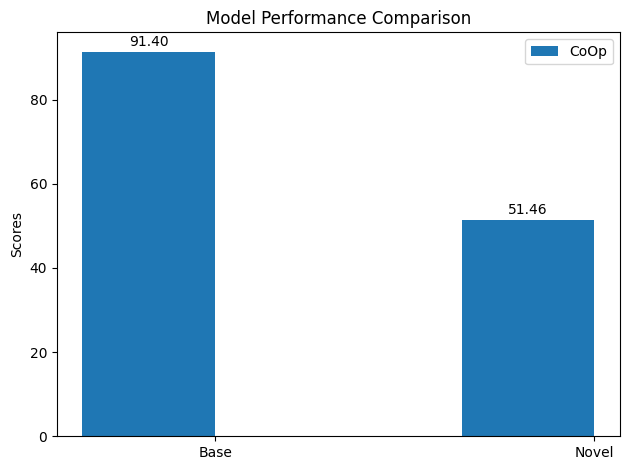

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Base', 'Novel']

coop_acc_list = [coop_base_acc, coop_novel_acc]

bar_width = 0.35
index = np.arange(len(metrics))
fig, ax = plt.subplots()
bar1 = ax.bar(index, coop_acc_list, bar_width, label='CoOp')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

add_value_labels(bar1)
plt.tight_layout()
plt.show()
